# Capstone Project
## Image classifier for the SVHN dataset



In [1]:
import tensorflow as tf
from scipy.io import loadmat

For the capstone project,  use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

The goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Load the dataset from your Drive folder

train = loadmat('/content/train_32x32.mat')
test = loadmat('/content/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded.


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Dropout,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
type(train)

dict

In [29]:
x_train = train['X']
y_train = train['y']
x_test  = test['X']
y_test  = test['y']

In [30]:
x_train = x_train/255
x_test = x_test/255

In [8]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((32, 32, 3, 73257), (73257, 1), (32, 32, 3, 26032), (26032, 1))

* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.


In [34]:
def display_images(num_samples,train_set,labels):
  index = np.random.choice(train_set.shape[3], num_samples, replace=False)
  fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))
  for i, ax in enumerate(axes):
      ax.imshow(train_set[:, :, :, index[i]])
      ax.set_title(f"Label: {y_train[index[i], 0]}")
      ax.axis('off')
  plt.show()

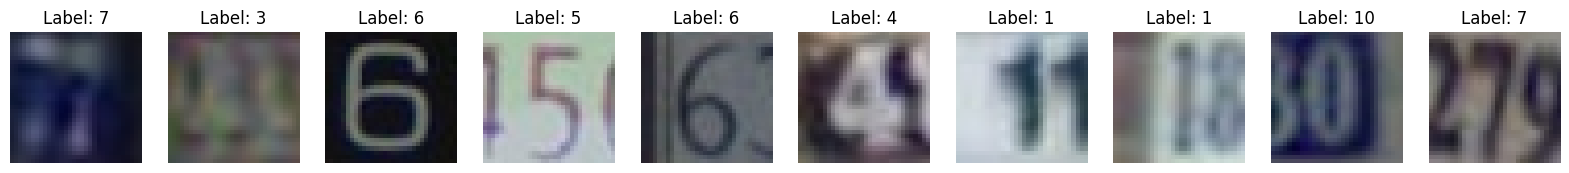

In [35]:
display_images(10,x_train,y_train)

* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._


In [36]:
x_train_gray = np.mean(x_train, axis=2, keepdims=True)
x_test_gray = np.mean(x_test, axis=2, keepdims=True)

In [37]:
x_train_gray.shape,x_test_gray.shape

((32, 32, 1, 73257), (32, 32, 1, 26032))

* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

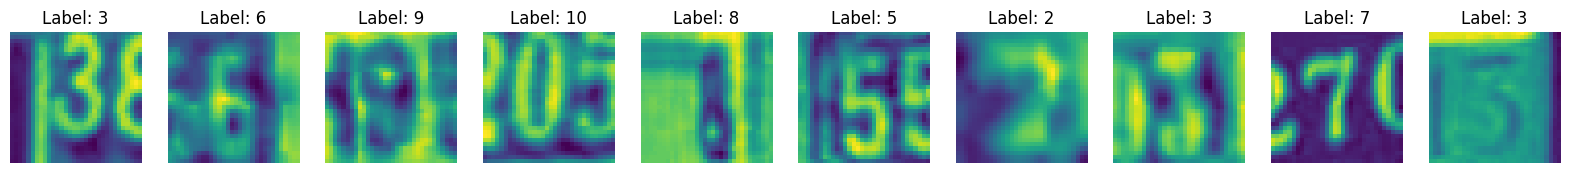

In [38]:
display_images(10,x_train_gray,y_test)

## 2. MLP neural network classifier


In [39]:
x_train= np.transpose(x_train_gray, (3, 0, 1, 2))
x_test= np.transpose(x_test_gray, (3, 0, 1, 2))

In [41]:
y_train = np.reshape(y_train, (-1,))
y_test = np.reshape(y_test,(-1,))

Restamos uno a los labels ya que el modelo reconoce etiquetas con valores desde 0 hasta n, y nosotros tenemos las etiquetas de 1 hasta 10.

In [44]:
y_train = y_train -1
y_test = y_test -1

In [46]:
input_shape = x_train[0].shape

model_MLP = Sequential(
    [
        Flatten(input_shape=input_shape),
        Dense(256,activation='relu',input_shape=input_shape),
        Dense(128,activation='relu'),
        Dense(64,activation='relu'),
        Dense(64,activation='relu'),
        Dense(10, activation='softmax')
    ]
)

In [47]:
model_MLP.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               262400    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 10)                650       
                                                                 
Total params: 308362 (1.18 MB)
Trainable params: 30836

In [50]:
model_MLP.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['sparse_categorical_accuracy']
)

In [51]:
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1
    )

In [52]:
def get_checkpoint_best_only(path):
    checkpoint = ModelCheckpoint(
        filepath=path,
        save_weights_only=True,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    return checkpoint
ModelCheckpointCallback_MLP = get_checkpoint_best_only('checkpoints_best_MLP/checkpoint')

In [53]:
history = model_MLP.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    validation_split=0.15,
    batch_size=64,
    callbacks=[early_stopping,ModelCheckpointCallback_MLP],
    verbose=1
    )

Epoch 1/30
962/973 [============================>.] - ETA: 0s - loss: 2.1003 - sparse_categorical_accuracy: 0.2481

973/973 [==============================] - 6s 6ms/step - loss: 2.0960 - sparse_categorical_accuracy: 0.2496 - val_loss: 1.7653 - val_sparse_categorical_accuracy: 0.3759
Epoch 2/30
973/973 [==============================] - ETA: 0s - loss: 1.5595 - sparse_categorical_accuracy: 0.4603

973/973 [==============================] - 6s 6ms/step - loss: 1.5595 - sparse_categorical_accuracy: 0.4603 - val_loss: 1.4214 - val_sparse_categorical_accuracy: 0.5222
Epoch 3/30
973/973 [==============================] - ETA: 0s - loss: 1.3425 - sparse_categorical_accuracy: 0.5516

973/973 [==============================] - 5s 5ms/step - loss: 1.3425 - sparse_categorical_accuracy: 0.5516 - val_loss: 1.3966 - val_sparse_categorical_accuracy: 0.5253
Epoch 4/30
970/973 [============================>.] - ETA: 0s - loss: 1.1925 - sparse_categorical_accuracy: 0.6129

973/973 [==============================] - 5s 5ms/step - loss: 1.1924 - sparse_categorical_accuracy: 0.6130 - val_loss: 1.1453 - val_sparse_categorical_accuracy: 0.6314
Epoch 5/30
973/973 [==============================] - ETA: 0s - loss: 1.0967 - sparse_categorical_accuracy: 0.6508

973/973 [==============================] - 7s 7ms/step - loss: 1.0967 - sparse_categorical_accuracy: 0.6508 - val_loss: 1.1167 - val_sparse_categorical_accuracy: 0.6446
Epoch 6/30
970/973 [============================>.] - ETA: 0s - loss: 1.0422 - sparse_categorical_accuracy: 0.6694

973/973 [==============================] - 5s 5ms/step - loss: 1.0427 - sparse_categorical_accuracy: 0.6693 - val_loss: 1.0367 - val_sparse_categorical_accuracy: 0.6752
Epoch 7/30
967/973 [============================>.] - ETA: 0s - loss: 1.0067 - sparse_categorical_accuracy: 0.6829

973/973 [==============================] - 6s 6ms/step - loss: 1.0073 - sparse_categorical_accuracy: 0.6827 - val_loss: 1.0433 - val_sparse_categorical_accuracy: 0.6699
Epoch 8/30
965/973 [============================>.] - ETA: 0s - loss: 0.9740 - sparse_categorical_accuracy: 0.6933

973/973 [==============================] - 5s 5ms/step - loss: 0.9739 - sparse_categorical_accuracy: 0.6932 - val_loss: 0.9975 - val_sparse_categorical_accuracy: 0.6830
Epoch 9/30
970/973 [============================>.] - ETA: 0s - loss: 0.9475 - sparse_categorical_accuracy: 0.7006

973/973 [==============================] - 5s 5ms/step - loss: 0.9474 - sparse_categorical_accuracy: 0.7007 - val_loss: 0.9708 - val_sparse_categorical_accuracy: 0.6891
Epoch 10/30
972/973 [============================>.] - ETA: 0s - loss: 0.9165 - sparse_categorical_accuracy: 0.7089

973/973 [==============================] - 6s 6ms/step - loss: 0.9165 - sparse_categorical_accuracy: 0.7089 - val_loss: 0.9318 - val_sparse_categorical_accuracy: 0.7017
Epoch 11/30
970/973 [============================>.] - ETA: 0s - loss: 0.8915 - sparse_categorical_accuracy: 0.7201

973/973 [==============================] - 5s 5ms/step - loss: 0.8914 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.9826 - val_sparse_categorical_accuracy: 0.6850
Epoch 12/30
968/973 [============================>.] - ETA: 0s - loss: 0.8682 - sparse_categorical_accuracy: 0.7253

973/973 [==============================] - 6s 6ms/step - loss: 0.8680 - sparse_categorical_accuracy: 0.7253 - val_loss: 0.9244 - val_sparse_categorical_accuracy: 0.7080
Epoch 13/30
963/973 [============================>.] - ETA: 0s - loss: 0.8475 - sparse_categorical_accuracy: 0.7316

973/973 [==============================] - 5s 5ms/step - loss: 0.8472 - sparse_categorical_accuracy: 0.7317 - val_loss: 0.8506 - val_sparse_categorical_accuracy: 0.7302
Epoch 14/30
973/973 [==============================] - ETA: 0s - loss: 0.8301 - sparse_categorical_accuracy: 0.7373

973/973 [==============================] - 5s 5ms/step - loss: 0.8301 - sparse_categorical_accuracy: 0.7373 - val_loss: 0.8536 - val_sparse_categorical_accuracy: 0.7285
Epoch 15/30
968/973 [============================>.] - ETA: 0s - loss: 0.8154 - sparse_categorical_accuracy: 0.7425

973/973 [==============================] - 6s 7ms/step - loss: 0.8160 - sparse_categorical_accuracy: 0.7423 - val_loss: 0.8329 - val_sparse_categorical_accuracy: 0.7375
Epoch 16/30
968/973 [============================>.] - ETA: 0s - loss: 0.7988 - sparse_categorical_accuracy: 0.7479

973/973 [==============================] - 5s 5ms/step - loss: 0.7984 - sparse_categorical_accuracy: 0.7480 - val_loss: 0.8495 - val_sparse_categorical_accuracy: 0.7285
Epoch 17/30
967/973 [============================>.] - ETA: 0s - loss: 0.7868 - sparse_categorical_accuracy: 0.7527

973/973 [==============================] - 6s 7ms/step - loss: 0.7870 - sparse_categorical_accuracy: 0.7527 - val_loss: 0.7949 - val_sparse_categorical_accuracy: 0.7525
Epoch 18/30
970/973 [============================>.] - ETA: 0s - loss: 0.7737 - sparse_categorical_accuracy: 0.7558

973/973 [==============================] - 5s 5ms/step - loss: 0.7735 - sparse_categorical_accuracy: 0.7560 - val_loss: 0.8185 - val_sparse_categorical_accuracy: 0.7418
Epoch 19/30
970/973 [============================>.] - ETA: 0s - loss: 0.7551 - sparse_categorical_accuracy: 0.7615

973/973 [==============================] - 5s 5ms/step - loss: 0.7550 - sparse_categorical_accuracy: 0.7615 - val_loss: 0.8523 - val_sparse_categorical_accuracy: 0.7362
Epoch 20/30
966/973 [============================>.] - ETA: 0s - loss: 0.7522 - sparse_categorical_accuracy: 0.7630

973/973 [==============================] - 6s 7ms/step - loss: 0.7522 - sparse_categorical_accuracy: 0.7631 - val_loss: 0.7778 - val_sparse_categorical_accuracy: 0.7555
Epoch 21/30
969/973 [============================>.] - ETA: 0s - loss: 0.7380 - sparse_categorical_accuracy: 0.7671

973/973 [==============================] - 5s 5ms/step - loss: 0.7390 - sparse_categorical_accuracy: 0.7667 - val_loss: 0.7738 - val_sparse_categorical_accuracy: 0.7599
Epoch 22/30
967/973 [============================>.] - ETA: 0s - loss: 0.7263 - sparse_categorical_accuracy: 0.7700

973/973 [==============================] - 6s 6ms/step - loss: 0.7262 - sparse_categorical_accuracy: 0.7701 - val_loss: 0.7720 - val_sparse_categorical_accuracy: 0.7612
Epoch 23/30
966/973 [============================>.] - ETA: 0s - loss: 0.7236 - sparse_categorical_accuracy: 0.7715

973/973 [==============================] - 5s 5ms/step - loss: 0.7235 - sparse_categorical_accuracy: 0.7716 - val_loss: 0.7541 - val_sparse_categorical_accuracy: 0.7659
Epoch 24/30
962/973 [============================>.] - ETA: 0s - loss: 0.7098 - sparse_categorical_accuracy: 0.7777

973/973 [==============================] - 5s 5ms/step - loss: 0.7093 - sparse_categorical_accuracy: 0.7778 - val_loss: 0.7747 - val_sparse_categorical_accuracy: 0.7599
Epoch 25/30
972/973 [============================>.] - ETA: 0s - loss: 0.7043 - sparse_categorical_accuracy: 0.7772

973/973 [==============================] - 6s 6ms/step - loss: 0.7046 - sparse_categorical_accuracy: 0.7771 - val_loss: 0.7678 - val_sparse_categorical_accuracy: 0.7603
Epoch 26/30
963/973 [============================>.] - ETA: 0s - loss: 0.6988 - sparse_categorical_accuracy: 0.7788

973/973 [==============================] - 5s 5ms/step - loss: 0.6983 - sparse_categorical_accuracy: 0.7790 - val_loss: 0.7573 - val_sparse_categorical_accuracy: 0.7669
Epoch 27/30
971/973 [============================>.] - ETA: 0s - loss: 0.6913 - sparse_categorical_accuracy: 0.7825

973/973 [==============================] - 6s 6ms/step - loss: 0.6913 - sparse_categorical_accuracy: 0.7825 - val_loss: 0.7434 - val_sparse_categorical_accuracy: 0.7694
Epoch 28/30
972/973 [============================>.] - ETA: 0s - loss: 0.6844 - sparse_categorical_accuracy: 0.7841

973/973 [==============================] - 5s 5ms/step - loss: 0.6844 - sparse_categorical_accuracy: 0.7841 - val_loss: 0.7458 - val_sparse_categorical_accuracy: 0.7710
Epoch 29/30
966/973 [============================>.] - ETA: 0s - loss: 0.6740 - sparse_categorical_accuracy: 0.7862

973/973 [==============================] - 5s 5ms/step - loss: 0.6736 - sparse_categorical_accuracy: 0.7863 - val_loss: 0.7340 - val_sparse_categorical_accuracy: 0.7740
Epoch 30/30
964/973 [============================>.] - ETA: 0s - loss: 0.6724 - sparse_categorical_accuracy: 0.7875

973/973 [==============================] - 7s 7ms/step - loss: 0.6716 - sparse_categorical_accuracy: 0.7879 - val_loss: 0.7708 - val_sparse_categorical_accuracy: 0.7614


In [54]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

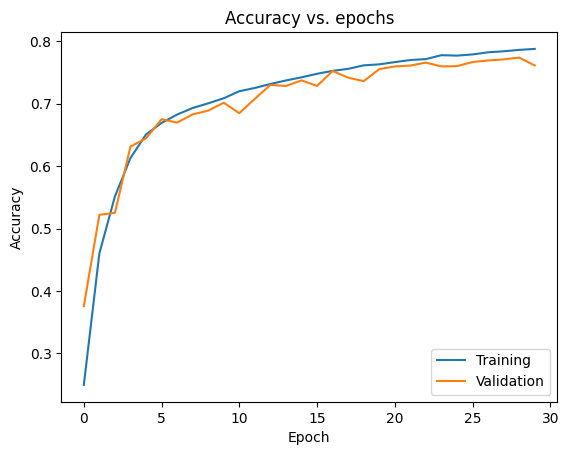

In [55]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

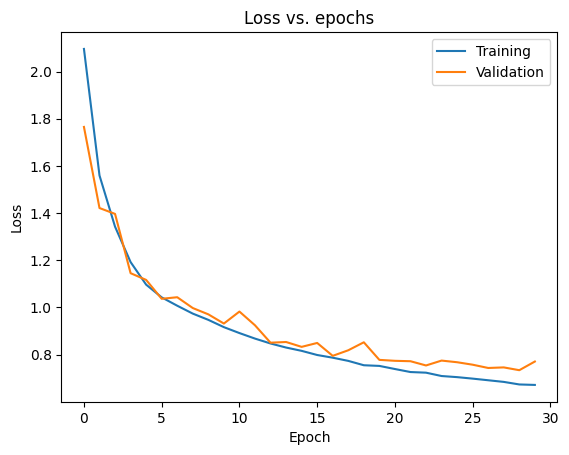

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [57]:
pd.DataFrame(history.history).tail(5)

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
25,0.698284,0.779036,0.757301,0.766858
26,0.691345,0.782456,0.743425,0.769406
27,0.684407,0.784078,0.745846,0.771044
28,0.673552,0.786343,0.734017,0.773956
29,0.671586,0.787869,0.770773,0.761398


In [58]:
def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))
    print('loss: {loss:0.3f}'.format(loss=test_loss))

In [59]:
get_test_accuracy(model_MLP, x_test,y_test)

accuracy: 0.738
loss: 0.874


## 3. CNN neural network classifier


In [75]:
model_cnn = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

In [76]:
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_5 (Bat  (None, 16, 16, 32)        128       
 chNormalization)                                                
                                                      

In [77]:
model_cnn.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['sparse_categorical_accuracy']
)

In [78]:
ModelCheckpointCallback_CNN = get_checkpoint_best_only('checkpoints_best_CNN/checkpoint')
history_cnn = model_cnn.fit(
    x=x_train,
    y=y_train,
    epochs=10,
    validation_split=0.15,
    batch_size=64,
    callbacks=[early_stopping,ModelCheckpointCallback_CNN],
    verbose=1
    )

Epoch 1/10
973/973 [==============================] - ETA: 0s - loss: 1.1413 - sparse_categorical_accuracy: 0.6161

973/973 [==============================] - 81s 81ms/step - loss: 1.1413 - sparse_categorical_accuracy: 0.6161 - val_loss: 0.5393 - val_sparse_categorical_accuracy: 0.8413
Epoch 2/10
973/973 [==============================] - ETA: 0s - loss: 0.5853 - sparse_categorical_accuracy: 0.8200

973/973 [==============================] - 81s 83ms/step - loss: 0.5853 - sparse_categorical_accuracy: 0.8200 - val_loss: 0.5121 - val_sparse_categorical_accuracy: 0.8497
Epoch 3/10
973/973 [==============================] - ETA: 0s - loss: 0.5027 - sparse_categorical_accuracy: 0.8473

973/973 [==============================] - 78s 80ms/step - loss: 0.5027 - sparse_categorical_accuracy: 0.8473 - val_loss: 0.4203 - val_sparse_categorical_accuracy: 0.8771
Epoch 4/10
973/973 [==============================] - ETA: 0s - loss: 0.4507 - sparse_categorical_accuracy: 0.8606

973/973 [==============================] - 80s 82ms/step - loss: 0.4507 - sparse_categorical_accuracy: 0.8606 - val_loss: 0.4739 - val_sparse_categorical_accuracy: 0.8620
Epoch 5/10
973/973 [==============================] - ETA: 0s - loss: 0.4176 - sparse_categorical_accuracy: 0.8717

973/973 [==============================] - 78s 80ms/step - loss: 0.4176 - sparse_categorical_accuracy: 0.8717 - val_loss: 0.4323 - val_sparse_categorical_accuracy: 0.8721
Epoch 6/10
973/973 [==============================] - ETA: 0s - loss: 0.3895 - sparse_categorical_accuracy: 0.8807

973/973 [==============================] - 78s 80ms/step - loss: 0.3895 - sparse_categorical_accuracy: 0.8807 - val_loss: 0.4222 - val_sparse_categorical_accuracy: 0.8793
Epoch 7/10
973/973 [==============================] - ETA: 0s - loss: 0.3684 - sparse_categorical_accuracy: 0.8859

973/973 [==============================] - 78s 80ms/step - loss: 0.3684 - sparse_categorical_accuracy: 0.8859 - val_loss: 0.4168 - val_sparse_categorical_accuracy: 0.8821
Epoch 8/10
973/973 [==============================] - ETA: 0s - loss: 0.3480 - sparse_categorical_accuracy: 0.8913

973/973 [==============================] - 81s 83ms/step - loss: 0.3480 - sparse_categorical_accuracy: 0.8913 - val_loss: 0.4097 - val_sparse_categorical_accuracy: 0.8850
Epoch 9/10
973/973 [==============================] - ETA: 0s - loss: 0.3326 - sparse_categorical_accuracy: 0.8947

973/973 [==============================] - 77s 79ms/step - loss: 0.3326 - sparse_categorical_accuracy: 0.8947 - val_loss: 0.4000 - val_sparse_categorical_accuracy: 0.8867
Epoch 10/10
973/973 [==============================] - ETA: 0s - loss: 0.3190 - sparse_categorical_accuracy: 0.8994

973/973 [==============================] - 79s 81ms/step - loss: 0.3190 - sparse_categorical_accuracy: 0.8994 - val_loss: 0.3870 - val_sparse_categorical_accuracy: 0.8891


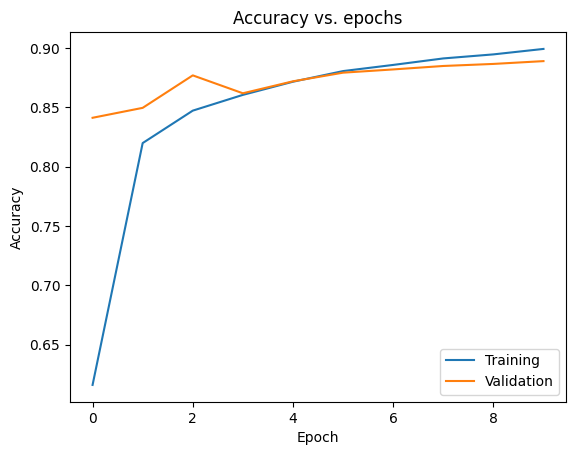

In [79]:
plt.plot(history_cnn.history['sparse_categorical_accuracy'])
plt.plot(history_cnn.history['val_sparse_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

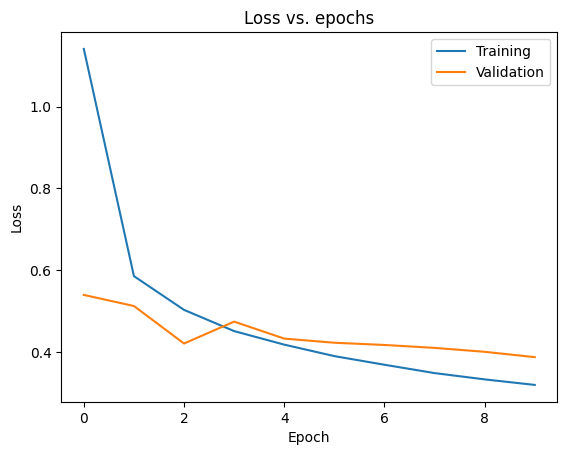

In [81]:
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [82]:
get_test_accuracy(model_cnn, x_test,y_test)

accuracy: 0.872
loss: 0.445


## 4. Get model predictions


In [36]:
#We can load the best estimated parameters for the weights and instantiate them in our model.
"""checkpoint_dir = '/content/checkpoints_best_CNN'
model_cnn.load_weights(checkpoint_dir)
get_test_accuracy(model_load, x_test, y_test)"""

"checkpoint_dir = '/content/checkpoints_best_CNN'\nmodel_cnn.load_weights(checkpoint_dir)\nget_test_accuracy(model_load, x_test, y_test)"

In [71]:
num_test_images = y_test.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = x_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]+1  #Add 1 by the -1 rest at the begining

### ***Predictions MLP model***

1/1 [==============================] - 0s 16ms/step


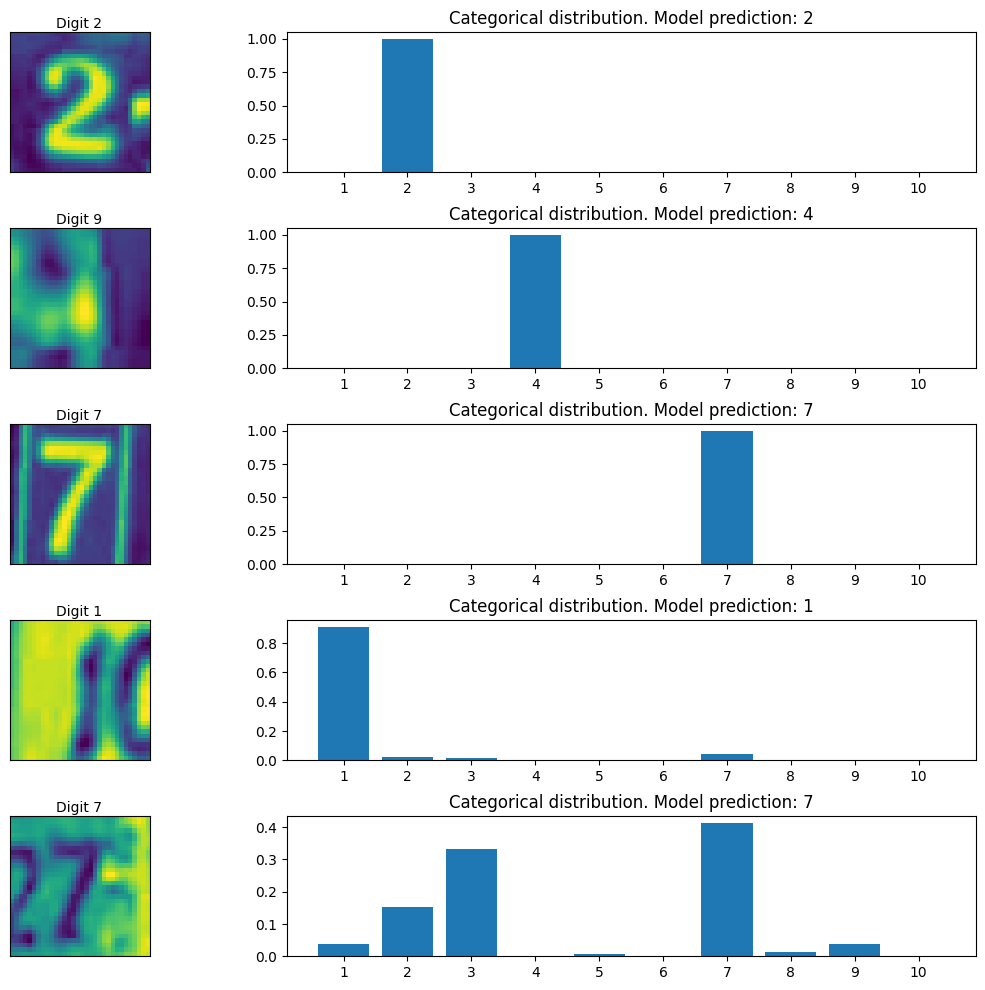

In [72]:
predictions_mlp = model_MLP.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions_mlp, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction))+1, prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction))+1)
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)+1}")

plt.show()

### ***Predictions CNN model***

1/1 [==============================] - 0s 116ms/step


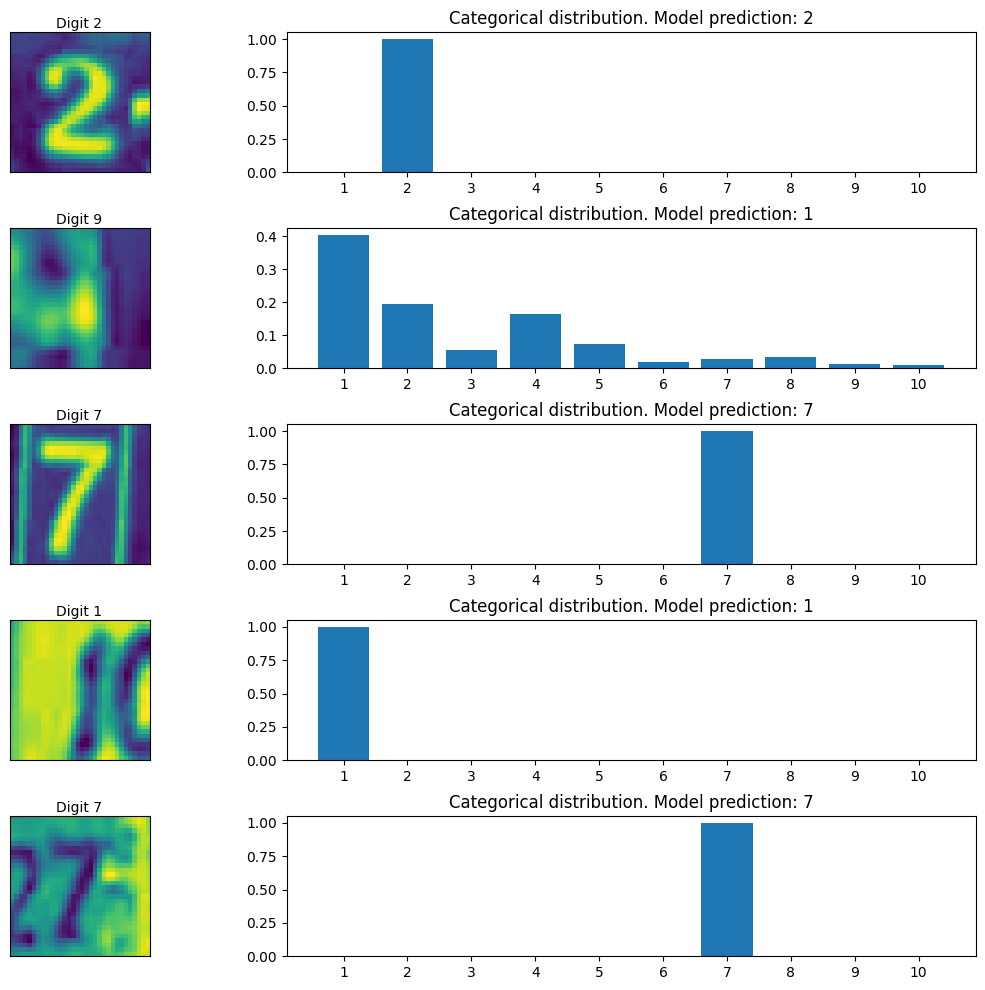

In [73]:
predictions_cnn = model_cnn.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions_cnn, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction))+1, prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction))+1)
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)+1}")

plt.show()

We can observe that CNN model is more exactly for prediction the correct digit.